In [17]:
from __future__ import absolute_import, division, print_function, unicode_literals


In [2]:
import sys
sys.path.insert(0, '/tf/pollock')

In [3]:
import logging
import os
import random
from collections import Counter
from importlib import reload


import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

import pollock
from pollock.models.model import PollockDataset, PollockModel, load_from_directory
import pollock.models.analysis as pollock_analysis

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [67]:
import tensorflow as tf
from tensorflow.keras import layers

tf.keras.backend.clear_session()  # For easy reset of notebook state.


In [5]:
DATA_DIR = '/home/estorrs/data/single_cell_classification'
MODEL_DIR = '/home/estorrs/pollock/models'

In [8]:
DATA_DIR = '/data/single_cell_classification'
MODEL_DIR = '/models'

In [9]:
run_name = 'pbmc_bench_10x-v3'

expression_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Inter-dataset',
                             'PbmcBench', '10Xv3', '10Xv3_pbmc1.csv')
label_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Inter-dataset',
                             'PbmcBench', '10Xv3', '10Xv3_pbmc1Labels.csv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Unnamed: 0'
sep=','
cell_type_key = 'x'

n_per_cell_type = 1000
epochs = 5
batch_size = 64

In [10]:
%%time
expression_df = pd.read_csv(
    expression_fp,
    sep=sep)
expression_df

CPU times: user 2min 17s, sys: 3.79 s, total: 2min 20s
Wall time: 2min 20s


,Unnamed: 0,TSPAN6,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,RP11-511P7.5,RP11-557N21.1,RP11-219A15.5,TRBV6-2,RP1-221C16.8,RP11-736N17.11,RP11-834C11.15,RP11-11M20.4,LLNLR-245B6.1,RP11-299P2.2
0,pbmc1_10X_v3_AAACCCACACTTGGGC,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,pbmc1_10X_v3_AAACCCATCTTACACT,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,pbmc1_10X_v3_AAAGAACAGCAGGCAT,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,pbmc1_10X_v3_AAAGAACTCAAAGACA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,pbmc1_10X_v3_AAAGTCCGTAGGCAGT,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19685,pbmc1_Seqwell_TTTTAGGAGAGG_R2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19686,pbmc1_Seqwell_TTTTATCCTTAT_R2,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19687,pbmc1_Seqwell_TTTTATGAAGCT_R2,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19688,pbmc1_Seqwell_TTTTCCGTCGCG_R2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [11]:
expression_df = expression_df.set_index(sample_column)
expression_df

,TSPAN6,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,STPG1,...,RP11-511P7.5,RP11-557N21.1,RP11-219A15.5,TRBV6-2,RP1-221C16.8,RP11-736N17.11,RP11-834C11.15,RP11-11M20.4,LLNLR-245B6.1,RP11-299P2.2
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
pbmc1_10X_v3_AAACCCACACTTGGGC,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
pbmc1_10X_v3_AAACCCATCTTACACT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pbmc1_10X_v3_AAAGAACAGCAGGCAT,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pbmc1_10X_v3_AAAGAACTCAAAGACA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pbmc1_10X_v3_AAAGTCCGTAGGCAGT,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pbmc1_Seqwell_TTTTAGGAGAGG_R2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pbmc1_Seqwell_TTTTATCCTTAT_R2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pbmc1_Seqwell_TTTTATGAAGCT_R2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
label_df = pd.read_csv(
    label_fp,
    sep=sep
    )
label_df

,x
0,CD4+ T cell
1,CD4+ T cell
2,CD4+ T cell
3,CD4+ T cell
4,CD4+ T cell
...,...
19685,Cytotoxic T cell
19686,CD4+ T cell
19687,CD14+ monocyte
19688,CD4+ T cell


In [13]:
adata = anndata.AnnData(X=expression_df.values, obs=label_df)
adata.obs.index = expression_df.index
adata.var.index = expression_df.columns
adata

Transforming to str index.


AnnData object with n_obs × n_vars = 19690 × 21905 
    obs: 'x'

In [14]:
counts = Counter(adata.obs[cell_type_key])
counts.most_common()

[('Cytotoxic T cell', 6728),
 ('CD4+ T cell', 4379),
 ('CD14+ monocyte', 3797),
 ('B cell', 2296),
 ('Megakaryocyte', 904),
 ('Natural killer cell', 818),
 ('CD16+ monocyte', 559),
 ('Dendritic cell', 209)]

In [22]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [23]:
adata

AnnData object with n_obs × n_vars = 17873 × 21211 
    obs: 'x', 'n_genes'
    var: 'n_cells'

In [25]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1)

... storing 'x' as categorical


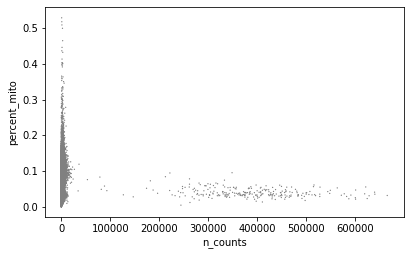

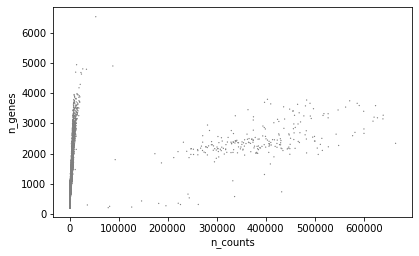

In [26]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [ ]:
adata = adata[adata.obs.n_genes < 2500, :]
adata = adata[adata.obs.percent_mito < 0.05, :]

In [123]:
class Sampling(layers.Layer):
  """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [124]:
class Encoder(layers.Layer):
  """Maps MNIST digits to a triplet (z_mean, z_log_var, z)."""

  def __init__(self,
               latent_dim=32,
               intermediate_dim=64,
               name='encoder',
               **kwargs):
    super(Encoder, self).__init__(name=name, **kwargs)
    self.dense_proj_1 = layers.Dense(intermediate_dim, activation='selu')
    self.dropout_layer_1 = layers.Dropout(.5)
    self.dense_proj_2 = layers.Dense(intermediate_dim, activation='selu')
    self.dense_mean = layers.Dense(latent_dim)
    self.dense_log_var = layers.Dense(latent_dim)
    self.sampling = Sampling()

  def call(self, inputs):
    x = self.dense_proj_1(inputs)
    x = self.dropout_layer_1(x)
    x = self.dense_proj_2(x)
     
    z_mean = self.dense_mean(x)
    z_log_var = self.dense_log_var(x)
    z = self.sampling((z_mean, z_log_var))
    return z_mean, z_log_var, z


class Decoder(layers.Layer):
  """Converts z, the encoded digit vector, back into a readable digit."""

  def __init__(self,
               original_dim,
               intermediate_dim=64,
               name='decoder',
               **kwargs):
    super(Decoder, self).__init__(name=name, **kwargs)
    self.dense_proj_1 = layers.Dense(intermediate_dim, activation='selu')
    self.dropout_layer_1 = layers.Dropout(.5)
    self.dense_proj_2 = layers.Dense(intermediate_dim, activation='selu')
    self.dense_output = layers.Dense(original_dim, activation='sigmoid')

  def call(self, inputs):
    x = self.dense_proj_1(inputs)
    x = self.dropout_layer_1(x)
    x = self.dense_proj_2(x)

        
    return self.dense_output(x)

In [125]:
def kl_loss_fn(model, inputs):
    z_mean, z_log_var, z = model.encoder(inputs)
    reconstructed = model.decoder(z)
    kl_loss = - 0.5 * tf.reduce_mean(
        z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
    return kl_loss

In [126]:
class VariationalAutoEncoder(tf.keras.Model):
  """Combines the encoder and decoder into an end-to-end model for training."""

  def __init__(self,
               original_dim,
               intermediate_dim=64,
               latent_dim=32,
               name='autoencoder',
               **kwargs):
    super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
    self.original_dim = original_dim
    self.encoder = Encoder(latent_dim=latent_dim,
                           intermediate_dim=intermediate_dim)
    self.decoder = Decoder(original_dim, intermediate_dim=intermediate_dim)

  def call(self, inputs):
    # self._set_inputs(inputs)
    z_mean, z_log_var, z = self.encoder(inputs)
#     print(z_mean, z_log_var, z)
    reconstructed = self.decoder(z)
    # Add KL divergence regularization loss.
    kl_loss = - 0.5 * tf.reduce_mean(
        z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
#     print(kl_loss)
    self.add_loss(kl_loss)
    return reconstructed

In [127]:
adata

AnnData object with n_obs × n_vars = 17873 × 21211 
    obs: 'x', 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells'

In [167]:
split = .8

idxs = np.arange(adata.shape[0])
np.random.shuffle(idxs)
train_idxs = idxs[:int(split * adata.shape[0])]
val_idxs = idxs[-int(split * adata.shape[0]):]

X = np.copy(adata.X)

X_train = X[train_idxs]
X_val = X[val_idxs]

y_train = adata.obs[cell_type_key][train_idxs]
y_val = adata.obs[cell_type_key][train_idxs]

X_train.shape, y_train.shape

((14298, 21211), (14298,))

In [168]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)

X_train = X_train / np.max(X_train)
X_val = X_val / np.max(X_train)

encoder = OrdinalEncoder()
y_train = encoder.fit_transform(np.asarray(y_train).reshape((-1, 1))).flatten()
y_val = encoder.transform(np.asarray(y_val).reshape((-1, 1))).flatten()

In [169]:
X_train

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 2.8810142e-05, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 2.8810142e-05, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [170]:
y_val.shape

(14298,)

In [171]:
train_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

val_dataset = tf.data.Dataset.from_tensor_slices(X_val)
val_dataset = val_dataset.batch(64)


In [172]:
original_dim = adata.shape[1]
vae = VariationalAutoEncoder(original_dim, 512, 128)  #, input_shape=(784,)

# vae.losses

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
mse_loss_fn = tf.keras.losses.MeanSquaredError()

loss_metric = tf.keras.metrics.Mean()

# Iterate over epochs.
for epoch in range(2):
  print('Start of epoch %d' % (epoch,))

  # Iterate over the batches of the dataset.
  for step, x_batch_train in enumerate(train_dataset):
    with tf.GradientTape() as tape:
      # !!! uncomment the following two lines to use workaround and skip !!!
      # if step == 0 and epoch == 0:
      #   vae._set_inputs(x_batch_train)
      reconstructed = vae(x_batch_train)
      # Compute reconstruction loss
      loss = mse_loss_fn(x_batch_train, reconstructed)
#       print(loss)
#       print(vae.losses)
      loss += sum(vae.losses)  # Add KLD regularization loss
#       print(loss)

    grads = tape.gradient(loss, vae.trainable_weights)
    optimizer.apply_gradients(zip(grads, vae.trainable_weights))

    loss_metric(loss)

    if step % 50 == 0:
      print('step %s: mean loss = %s' % (step, loss_metric.result()))
#       z_mean, z_log_var, z = vae.encoder(X_val)
#       reconstructed = vae.decoder(z)
    

#       val_recon_loss = mse_loss_fn(X_val, reconstructed)

#       print('step %s: mean val loss = %s' % (step, val_recon_loss / X_val.shape[0]))
    
#   for step, x_batch_val in enumerate(val_dataset):
#     reconstructed = vae(x_batch_val)
#     loss = mse_loss_fn(x_batch_val, reconstructed)
#     loss += kl_loss_fn(vae, x_batch_val)
#     if step % 100 == 0:
#       print('step %s: mean val loss = %s' % (step, loss))

Start of epoch 0
step 0: mean loss = tf.Tensor(0.25159416, shape=(), dtype=float32)
step 0: mean val loss = tf.Tensor(nan, shape=(), dtype=float32)
step 50: mean loss = tf.Tensor(0.06702688, shape=(), dtype=float32)
step 50: mean val loss = tf.Tensor(nan, shape=(), dtype=float32)
step 100: mean loss = tf.Tensor(0.043966115, shape=(), dtype=float32)
step 100: mean val loss = tf.Tensor(nan, shape=(), dtype=float32)
step 150: mean loss = tf.Tensor(0.034457777, shape=(), dtype=float32)
step 150: mean val loss = tf.Tensor(nan, shape=(), dtype=float32)
step 200: mean loss = tf.Tensor(0.028005714, shape=(), dtype=float32)
step 200: mean val loss = tf.Tensor(nan, shape=(), dtype=float32)
Start of epoch 1
step 0: mean loss = tf.Tensor(0.025382254, shape=(), dtype=float32)
step 0: mean val loss = tf.Tensor(nan, shape=(), dtype=float32)
step 50: mean loss = tf.Tensor(0.020933967, shape=(), dtype=float32)
step 50: mean val loss = tf.Tensor(nan, shape=(), dtype=float32)
step 100: mean loss = tf.Ten

In [53]:
# (x_train, _), _ = tf.keras.datasets.mnist.load_data()
# x_train = x_train.reshape(60000, 784).astype('float32') / 255

# train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
# train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

In [186]:
train_embeddings, _, _ = vae.encoder(X_train)
val_embeddings, _, _ = vae.encoder(X_val)

In [187]:
train_embeddings = train_embeddings.numpy()
val_embeddings = val_embeddings.numpy()

In [188]:
from sklearn.ensemble import RandomForestClassifier

In [189]:
clf = RandomForestClassifier()

In [190]:
clf.fit(train_embeddings, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [191]:
clf.score(train_embeddings, y_train)

1.0

In [192]:
clf.score(val_embeddings, y_val)

0.20065743460623864

In [166]:
probs = clf.predict_proba(val_embeddings)

ValueError: buffer source array is read-only